In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.image as mpimg
import cv2
import glob
import os
import keras
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


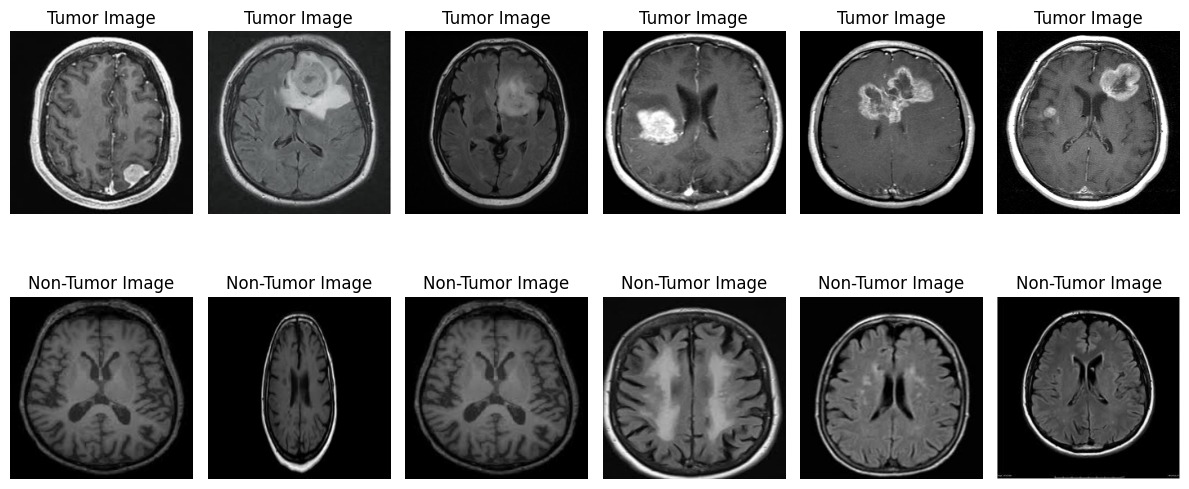

In [4]:
yes_folder_path = "/content/drive/MyDrive/DS Project Dataset/brain_tumor_dataset/yes"
no_folder_path = "/content/drive/MyDrive/DS Project Dataset/brain_tumor_dataset/no"

def load_images_from_directory(directory):
    image_list = []
    for filename in glob.glob(directory + "/*.jpg"):  # Adjust file extension if necessary
        img = cv2.imread(filename)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize image to standard format
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            image_list.append(img)
    return image_list

tumor_images = load_images_from_directory(yes_folder_path)
no_tumor_images = load_images_from_directory(no_folder_path)

num_images = 6
plt.figure(figsize=(12, 6))

for i in range(min(num_images, len(tumor_images))):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(tumor_images[i])
    plt.axis('off')
    plt.title('Tumor Image')

for i in range(min(num_images, len(no_tumor_images))):
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(no_tumor_images[i])
    plt.axis('off')
    plt.title('Non-Tumor Image')

plt.tight_layout()
plt.show()

In [5]:
def load_images(folders, label_map):
    images = []
    labels = []

    for folder in folders:
        for category in os.listdir(folder):
            category_path = os.path.join(folder, category)
            if os.path.isdir(category_path):
                if category in label_map:
                    label = label_map[category]
                    file_list = os.listdir(category_path)
                    for filename in file_list:
                        img_path = os.path.join(category_path, filename)
                        image = cv2.imread(img_path)
                        image = cv2.resize(image, (224, 224))
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image)
                        labels.append(label)

    return np.array(images), np.array(labels)

data_folders = [
    '/content/drive/MyDrive/DS Project Dataset/brain_tumor_dataset',
]

# encoding the labels
label_map = {'no': 0, 'yes': 1}

images, labels = load_images(data_folders, label_map)

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (253, 224, 224, 3)
Shape of labels: (253,)


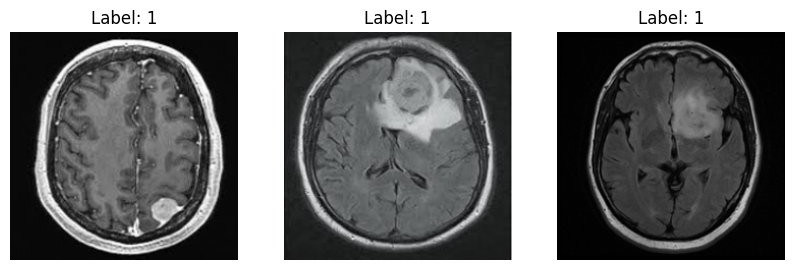

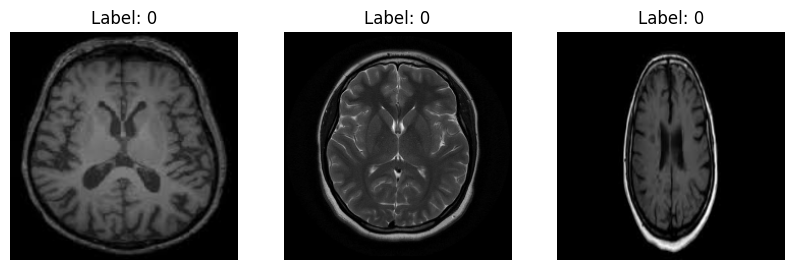

In [6]:
def filter_images_by_label(images, labels, label_value, num_images=3):
    filtered_images = []
    filtered_labels = []
    count = 0
    for image, label in zip(images, labels):
        if label == label_value:
            filtered_images.append(image)
            filtered_labels.append(label)
            count += 1
            if count == num_images:
                break
    return filtered_images, filtered_labels

# Display 3 images with label 1
label_1_images, label_1_labels = filter_images_by_label(images, labels, 1, num_images=3)
plt.figure(figsize=(10, 5))
for i in range(len(label_1_images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(label_1_images[i])
    plt.title(f"Label: {label_1_labels[i]}")
    plt.axis('off')
plt.show()

# Display 3 images with label 0
label_0_images, label_0_labels = filter_images_by_label(images, labels, 0, num_images=3)
plt.figure(figsize=(10, 5))
for i in range(len(label_0_images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(label_0_images[i])
    plt.title(f"Label: {label_0_labels[i]}")
    plt.axis('off')
plt.show()

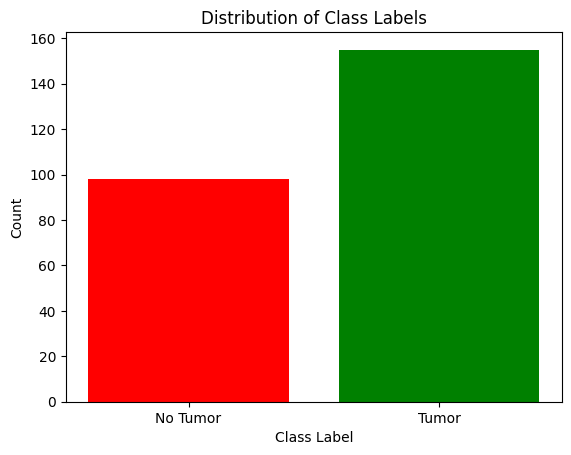

In [7]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Plot the counts
plt.bar(unique_labels, label_counts, color=['red', 'green'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [8]:
num_yes_images = sum(labels == 1)

num_no_images = sum(labels == 0)

print(f"Number of images with label 'yes': {num_yes_images}")
print(f"Number of images with label 'no': {num_no_images}")

Number of images with label 'yes': 155
Number of images with label 'no': 98


#**Data Preprocessing**

In [9]:
images_copy = images.copy()

print("Shape of Copied images:", images_copy.shape)

Shape of Copied images: (253, 224, 224, 3)


In [10]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)

    # removing noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    c = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(c)

    cropped_image = image[y:y+h, x:x+w]

    resized_image = cv2.resize(cropped_image, (224, 224))

    return resized_image

for i in range(len(images_copy)):
    images_copy[i] = preprocess_image(images_copy[i])

images_copy = [cv2.resize(img, (128, 128)) for img in images_copy]

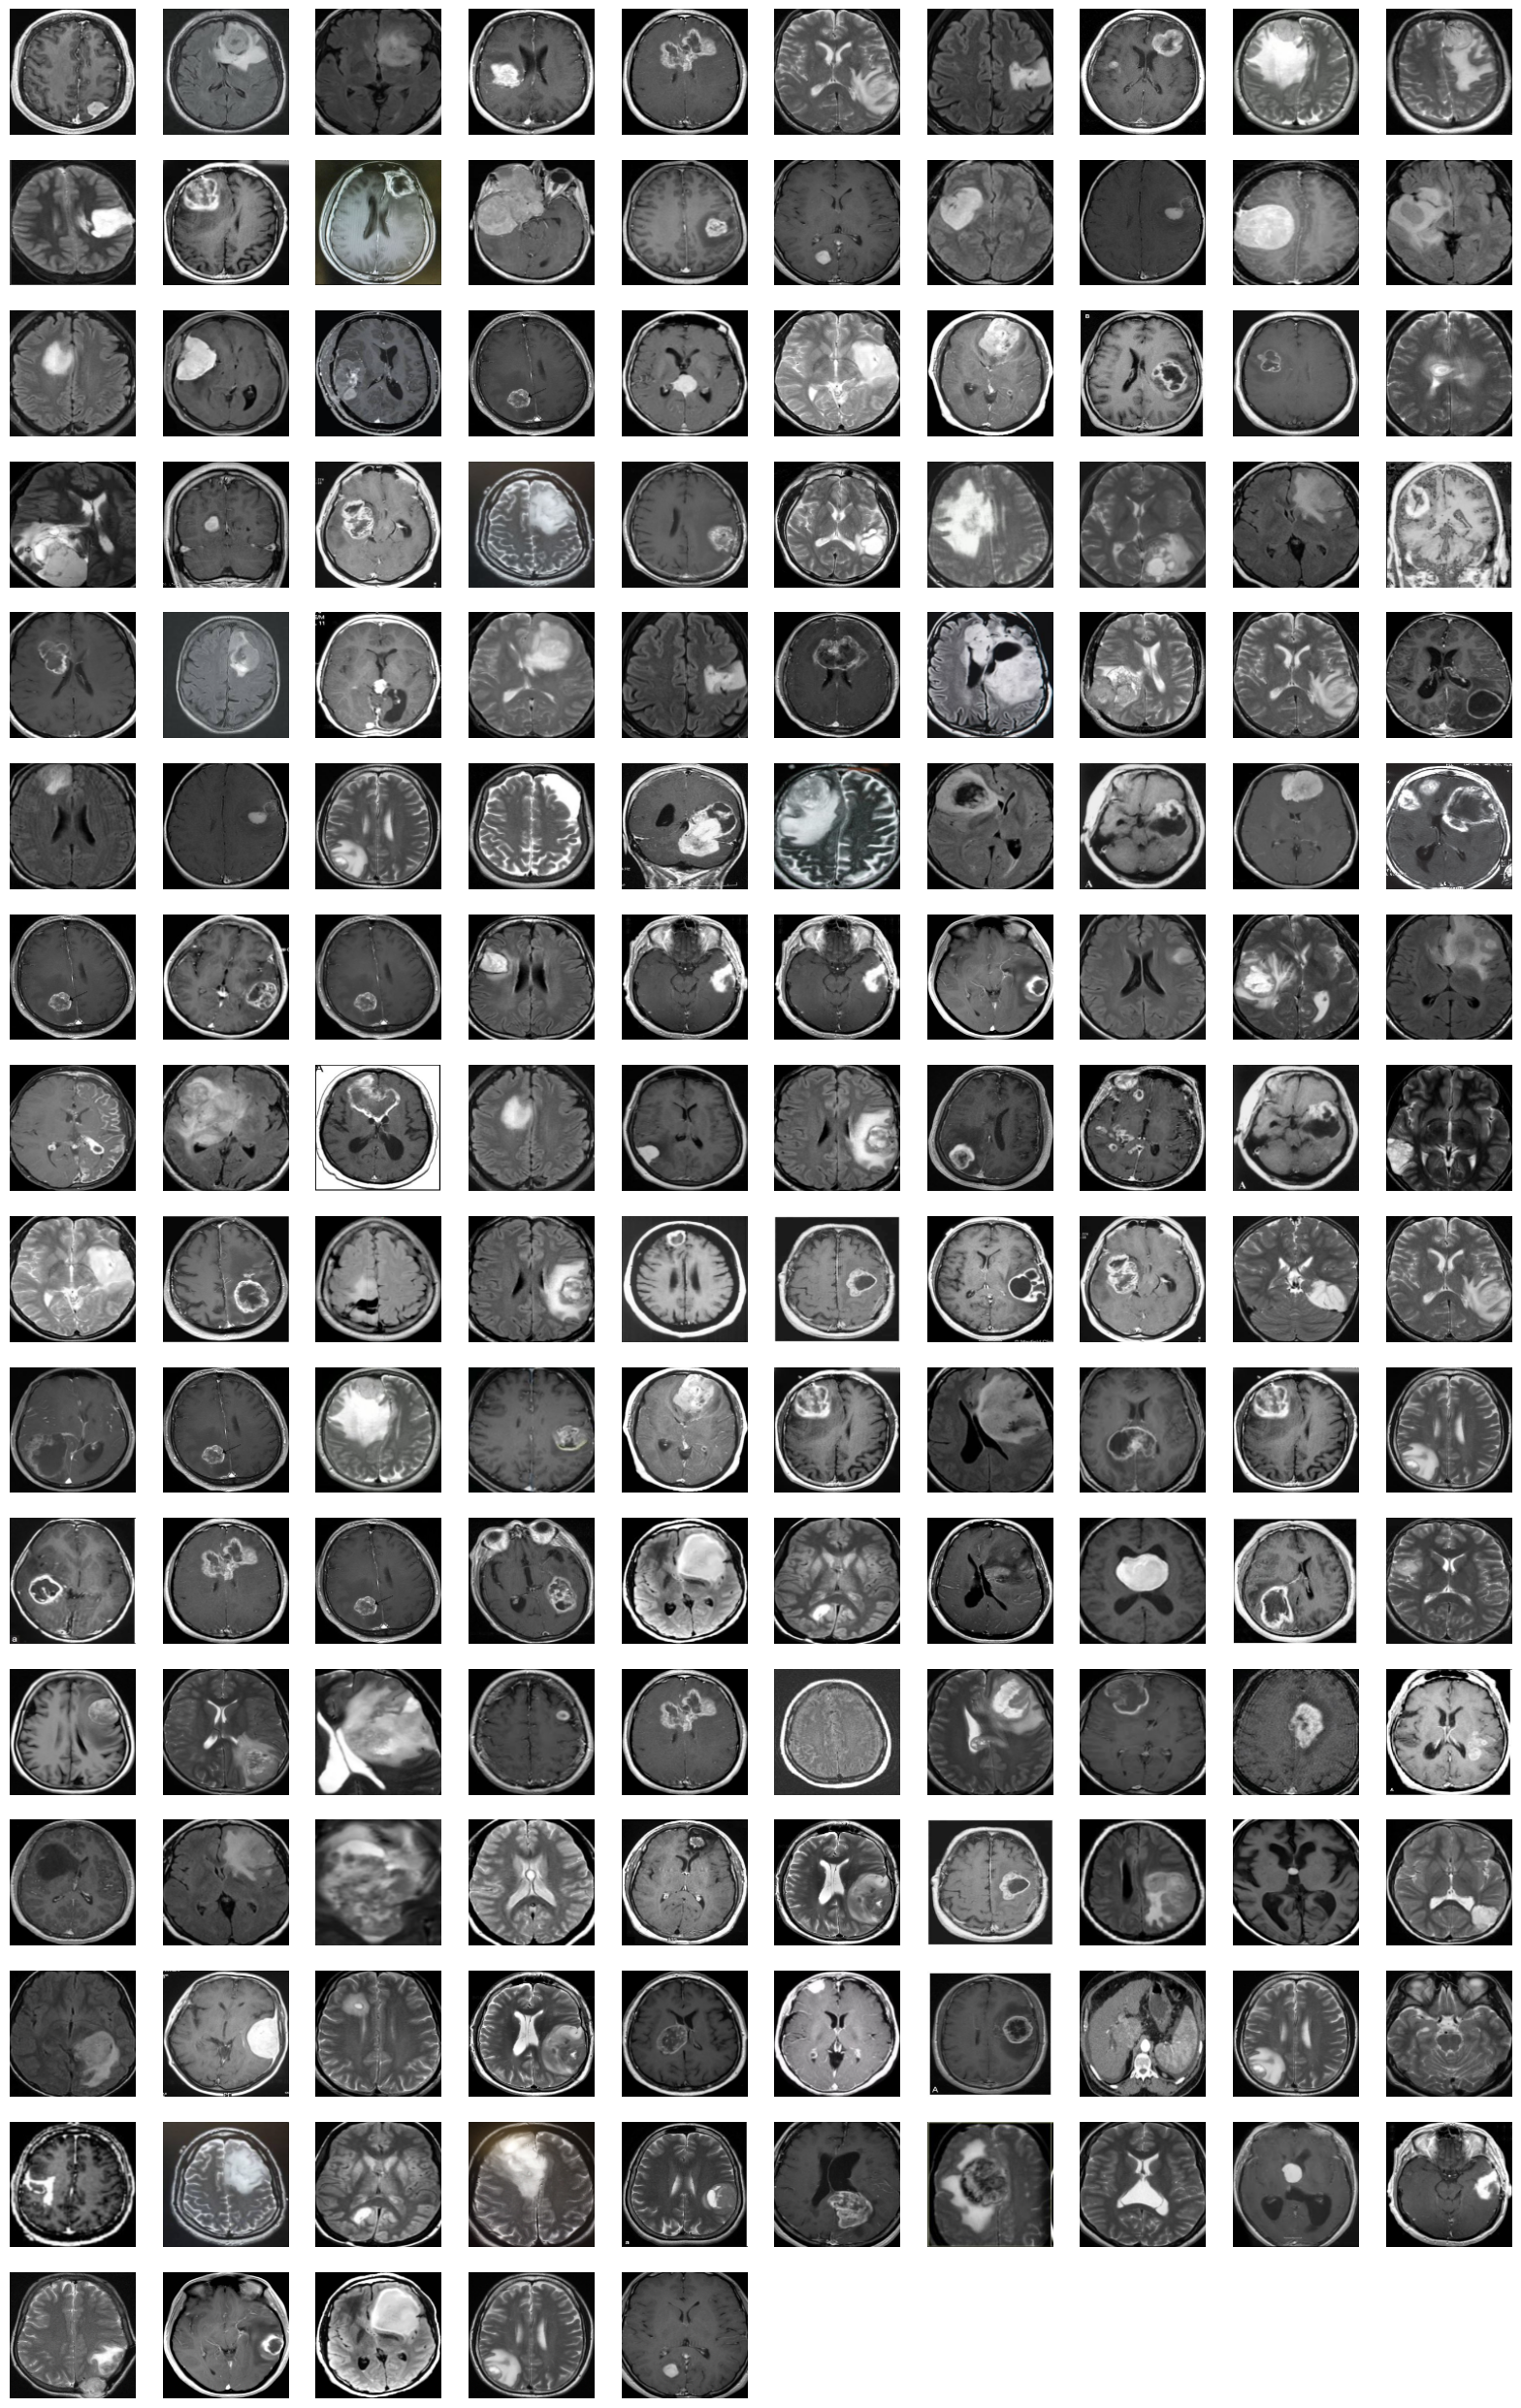

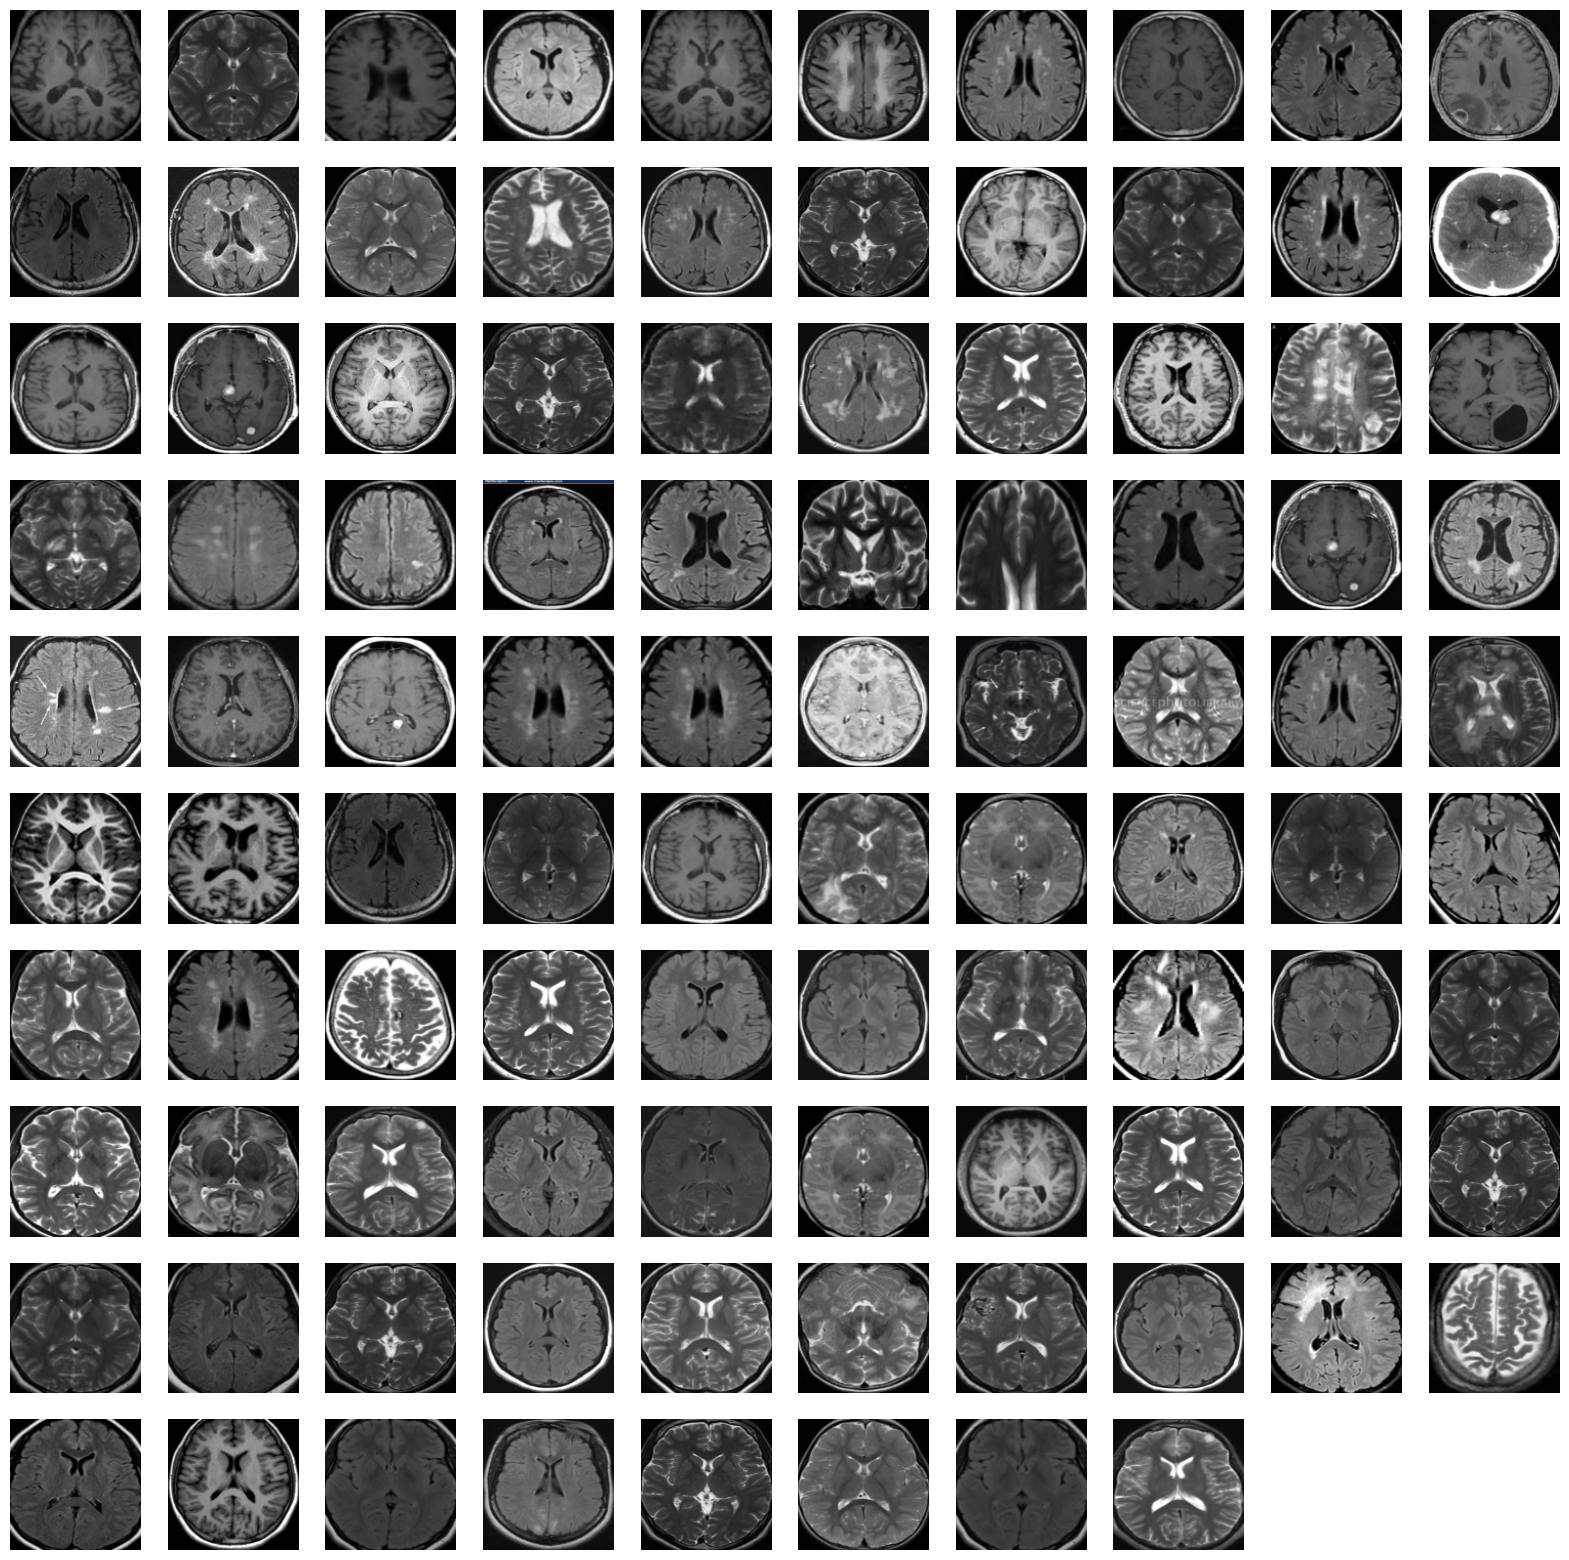

In [11]:
def filter_images_by_label(images_copy, labels, label_value):
    filtered_images = []
    filtered_labels = []
    for image, label in zip(images_copy, labels):
        if label == label_value:
            filtered_images.append(image)
            filtered_labels.append(label)
    return filtered_images, filtered_labels

# label 1
label_1_images, label_1_labels = filter_images_by_label(images_copy, labels, 1)
num_label_1 = len(label_1_images)
rows_label_1 = (num_label_1 // 10) + 1
plt.figure(figsize=(20, rows_label_1 * 2))
for i in range(num_label_1):
    plt.subplot(rows_label_1, 10, i + 1)
    plt.imshow(label_1_images[i])
    plt.axis('off')
plt.show()

# label 0
label_0_images, label_0_labels = filter_images_by_label(images_copy, labels, 0)
num_label_0 = len(label_0_images)
rows_label_0 = (num_label_0 // 10) + 1
plt.figure(figsize=(20, rows_label_0 * 2))
for i in range(num_label_0):
    plt.subplot(rows_label_0, 10, i + 1)
    plt.imshow(label_0_images[i])
    plt.axis('off')
plt.show()

#**Splitting Data into Training, Testing and Validation**

---



In [ ]:
images_shuffled, labels_shuffled = shuffle(images_copy, labels, random_state=42)

# 80% training, 20% remaining
X_train, X_remaining, Y_train, Y_remaining = train_test_split(images_shuffled, labels_shuffled, test_size=0.2, random_state=42)

# 50% of remaining for validation, 50% for testing
X_val, X_test, Y_val, Y_test = train_test_split(X_remaining, Y_remaining, test_size=0.5, random_state=42)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (202, 128, 128, 3) (202,)
Validation set shape: (25, 128, 128, 3) (25,)
Test set shape: (26, 128, 128, 3) (26,)


#**Normalization**

In [ ]:
# Normalize the images to range [0, 1]
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [ ]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)
model = build_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")

history = model.fit(
    X_train, Y_train,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50
7/7 [==============================] - 10s 1s/step - loss: 0.7123 - accuracy: 0.5545 - val_loss: 0.5777 - val_accuracy: 0.7200
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 9s 1s/step - loss: 0.6487 - accuracy: 0.6238 - val_loss: 0.6019 - val_accuracy: 0.7200
Epoch 3/50
7/7 [==============================] - 7s 931ms/step - loss: 0.6340 - accuracy: 0.6485 - val_loss: 0.5540 - val_accuracy: 0.7600
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 0.5726 - accuracy: 0.7327 - val_loss: 0.5587 - val_accuracy: 0.6800
Epoch 5/50
7/7 [==============================] - 6s 914ms/step - loss: 0.5281 - accuracy: 0.7525 - val_loss: 0.5323 - val_accuracy: 0.7600
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 0.4747 - accuracy: 0.7921 - val_loss: 0.5509 - val_accuracy: 0.7200
Epoch 7/50
7/7 [==============================] - 7s 922ms/step - loss: 0.4731 - accuracy: 0.7822 - val_loss: 0.5318 - val_accuracy: 0.7600
Epoch 8/50
7/7 [==============================] - 15s 2s/step - loss: 0.4521 - accuracy: 0.8020 - val_loss: 0.5286 - val_accuracy: 0.7200
Epoch 9/50
7/7 [==========================

#**Accuracy Score**

In [ ]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 326ms/step - loss: 0.5981 - accuracy: 0.6538


[0.5980530977249146, 0.6538461446762085]

#**Confusion Matrix**

1/1 [==============================] - 0s 277ms/step


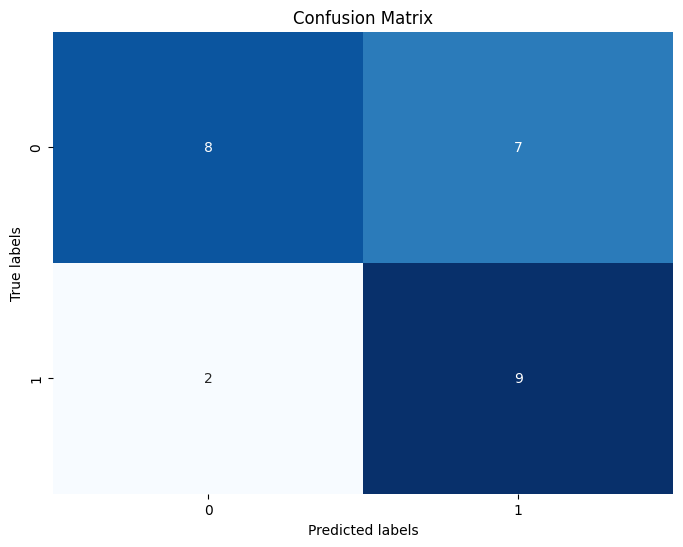

In [ ]:
y_pred = model.predict(X_test)
threshold = 0.5

y_pred_classes = (y_pred > threshold).astype(int)

conf_mat = confusion_matrix(Y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

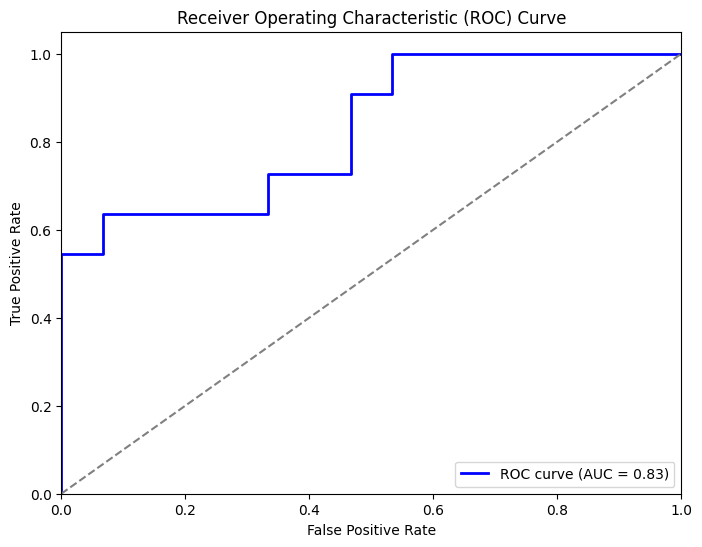

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(Y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()